# **Thesis - Predicting order_total_paid_per_day**

The objective here is to determine wether meteorological conditions have an impact or not on the final result.

### Step 1 

- Make a first prediction on the dataset itself without any meteorological feature to see what is the result and what are the pain points
- trying out different algorithms


### Step 2

Repeat the same process with adding the features to see if there is any improvements or not

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.pyplot import figure
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = pd.read_csv("BQ_fox.csv")
df

,order_date,week_day,order_item_delivery_address_region,order_total_paid_per_day
0,2020-01-01,Wednesday,corsica,420.05
1,2020-01-01,Wednesday,occitania,9791.06
2,2020-01-01,Wednesday,brittany,3140.09
3,2020-01-01,Wednesday,grand est,6760.79
4,2020-01-01,Wednesday,new aquitaine,3907.70
...,...,...,...,...
24185,2023-12-31,Sunday,bourgogne-franche-comte,6964.15
24186,2023-12-31,Sunday,grand est,26620.30
24187,2023-12-31,Sunday,auvergne-rhone-alpes,59739.43
24188,2023-12-31,Sunday,provence-alpes-cote d'azur,40683.11


In [2]:
# Making sure the columns' names are formatted the same way before going into data cleaning

df.columns = [column.lower().replace(' ', '_') for column in df.columns]

## **Cleaning phase**

In [3]:
# Checking if some columns have the wrong type
# Some observations here, we can clearly see that columns are not in the good format

# I notice, I do not have the region all the time, what I should do here since I dont have a lot of nulls is just removed them 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24190 entries, 0 to 24189
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   order_date                          24190 non-null  object 
 1   week_day                            24190 non-null  object 
 2   order_item_delivery_address_region  23439 non-null  object 
 3   order_total_paid_per_day            24190 non-null  float64
dtypes: float64(1), object(3)
memory usage: 756.1+ KB


In [4]:
df = df.dropna(subset=["order_item_delivery_address_region"])
df["order_item_delivery_address_region"].isna().sum()

0

In [5]:
# I want to pass the order date as a datetime

df['order_date'] = pd.to_datetime(df['order_date'], utc=True)
df['order_date'].dtypes


/var/folders/j9/8ym4b6n54plc1gt5xcwrqj_r0000gn/T/ipykernel_58937/3268251478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['order_date'] = pd.to_datetime(df['order_date'], utc=True)


datetime64[ns, UTC]

In [6]:
# identifying some problems here

df["order_item_delivery_address_region"].value_counts()

order_item_delivery_address_region
nouvelle-aquitaine                     1461
brittany                               1461
grand est                              1461
occitania                              1461
provence-alpes-cote d'azur             1461
centre-val de loire                    1461
bourgogne-franche-comte                1461
hauts-de-france                        1461
auvergne-rhone-alpes                   1461
ile-de-france                          1461
pays de la loire                       1461
normandy                               1461
corsica                                1443
centre-loire valley                    1117
new aquitaine                          1117
nord-pas-de-calais and picardy         1114
guadeloupe                              429
metropolitan france                     301
saint martin (france)                   135
martinique                               88
saint barthelemy                         39
french guiana                            

In [7]:
region_mapping = {
    # Régions métropolitaines
    "nouvelle-aquitaine": "Nouvelle-Aquitaine",
    "new aquitaine": "Nouvelle-Aquitaine",
    "New Aquitaine": "Nouvelle-Aquitaine",
    "brittany": "Bretagne",
    "grand est": "Grand Est",
    "occitania": "Occitanie",
    "provence-alpes-cote d'azur": "Provence-Alpes-Côte d'Azur",
    "centre-val de loire": "Centre-Val de Loire",
    "centre-loire valley": "Centre-Val de Loire",
    "bourgogne-franche-comte": "Bourgogne-Franche-Comté",
    "hauts-de-france": "Hauts-de-France",
    "nord-pas-de-calais and picardy": "Hauts-de-France",
    "Nord-Pas-de-Calais and Picardy": "Hauts-de-France",
    "auvergne-rhone-alpes": "Auvergne-Rhône-Alpes",
    "pays de la loire": "Pays de la Loire",
    "normandy": "Normandie",
    "ile-de-france": "Île-de-France",
    "Ile-de-France": "Île-de-France",
    # Régions d'outre-mer
    "corsica": "Corse",
    "Corsica": "Corse",
    "guadeloupe": "Guadeloupe",
    "martinique": "Martinique",
    "french guiana": "Guyane",
    "french polynesia": "Polynésie Française",
    "saint martin (france)": "Saint-Martin",
    "saint barthelemy": "Saint-Barthélemy",
    "saint pierre and miquelon": "Saint-Pierre-et-Miquelon",
    "french southern and antarctic lands": "Terres Australes et Antarctiques Françaises",
    # Métropole
    "metropolitan france": "France Métropolitaine",
}

# Appliquer la correspondance
df["order_item_delivery_address_region"] = df["order_item_delivery_address_region"].str.lower().map(region_mapping).fillna("Autre")

# Résultat
df["order_item_delivery_address_region"].value_counts()

/var/folders/j9/8ym4b6n54plc1gt5xcwrqj_r0000gn/T/ipykernel_58937/499178240.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["order_item_delivery_address_region"] = df["order_item_delivery_address_region"].str.lower().map(region_mapping).fillna("Autre")


order_item_delivery_address_region
Hauts-de-France                                2579
Nouvelle-Aquitaine                             2579
Centre-Val de Loire                            2578
Île-de-France                                  1478
Corse                                          1470
Normandie                                      1461
Occitanie                                      1461
Auvergne-Rhône-Alpes                           1461
Pays de la Loire                               1461
Bourgogne-Franche-Comté                        1461
Provence-Alpes-Côte d'Azur                     1461
Grand Est                                      1461
Bretagne                                       1461
Guadeloupe                                      429
France Métropolitaine                           301
Saint-Martin                                    135
Martinique                                       88
Saint-Barthélemy                                 39
Guyane                       

In [8]:
# I remove France metropolitaine and the others (not enough values)

df = df[df['order_item_delivery_address_region'] != 'France Métropolitaine']
df = df[df['order_item_delivery_address_region'] != 'Saint-Martin']
df = df[df['order_item_delivery_address_region'] != 'Martinique']
df = df[df['order_item_delivery_address_region'] != 'Saint-Barthélemy']
df = df[df['order_item_delivery_address_region'] != 'Guyane']
df = df[df['order_item_delivery_address_region'] != 'Polynésie Française']
df = df[df['order_item_delivery_address_region'] != 'Autre']
df = df[df['order_item_delivery_address_region'] != 'Terres Australes et Antarctiques Françaises']
df = df[df['order_item_delivery_address_region'] != 'Saint-Pierre-et-Miquelon']

df["order_item_delivery_address_region"].value_counts()

order_item_delivery_address_region
Nouvelle-Aquitaine            2579
Hauts-de-France               2579
Centre-Val de Loire           2578
Île-de-France                 1478
Corse                         1470
Occitanie                     1461
Bretagne                      1461
Grand Est                     1461
Provence-Alpes-Côte d'Azur    1461
Bourgogne-Franche-Comté       1461
Auvergne-Rhône-Alpes          1461
Pays de la Loire              1461
Normandie                     1461
Guadeloupe                     429
Name: count, dtype: int64

## **EDA**

In [9]:
df.describe().apply(lambda x: round(x,2))

,order_total_paid_per_day
count,22801.00
mean,24096.90
std,39445.65
min,3.51
25%,4865.91
50%,13662.94
75%,30206.95
max,3491180.32


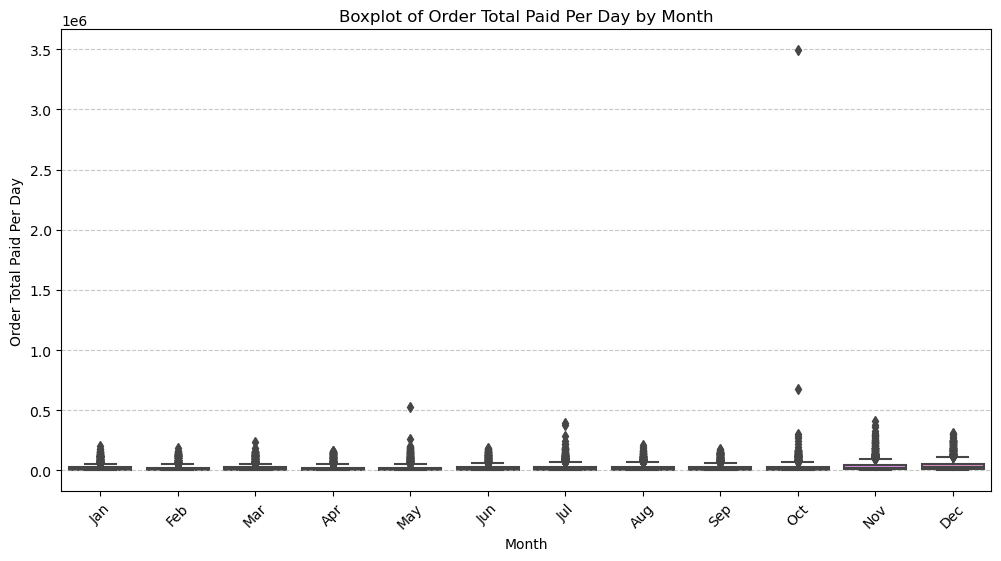

In [10]:
# checking outliers

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

# Extract the month from the order_date / doing the same for year and day so its done
df["year"] = df["order_date"].dt.year
df["month"] = df["order_date"].dt.month
df["day"] = df["order_date"].dt.month

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="month", y="order_total_paid_per_day", data=df)
plt.title("Boxplot of Order Total Paid Per Day by Month")
plt.xlabel("Month")
plt.ylabel("Order Total Paid Per Day")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# I detect 1 outlier, that might altern the quality of the prediction so I will remove this value that makes not much -
# - sense (even though it could be real)

In [11]:
max_value = df["order_total_paid_per_day"].max()

# Supprimer la ligne contenant cette valeur
df = df[df["order_total_paid_per_day"] != max_value]

df["order_total_paid_per_day"].max()

673503.8899999858

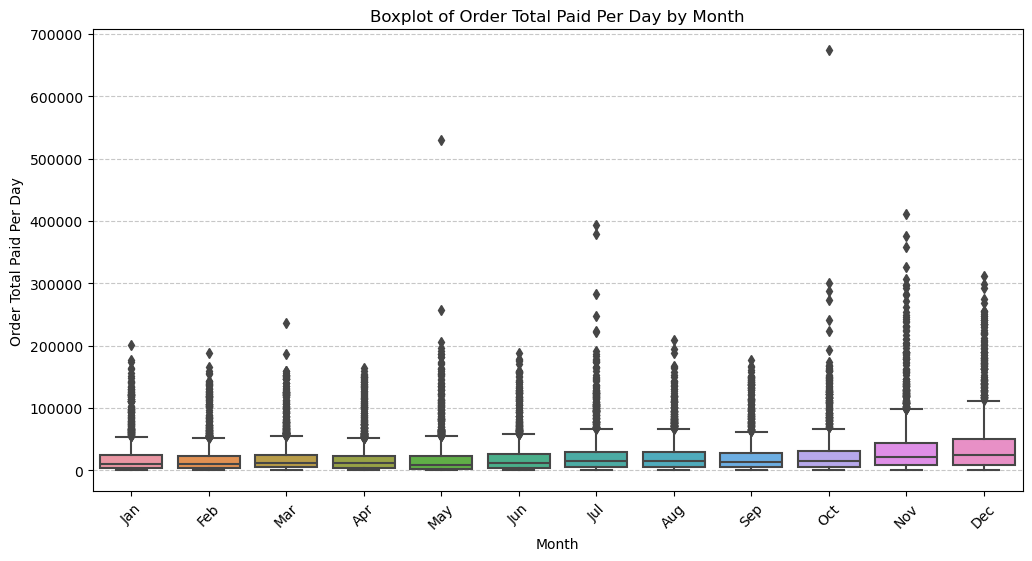

In [12]:
df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

# Extract the month from the order_date / doing the same for year and day so its done
df["year"] = df["order_date"].dt.year
df["month"] = df["order_date"].dt.month
df["day"] = df["order_date"].dt.month

# Create a boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="month", y="order_total_paid_per_day", data=df)
plt.title("Boxplot of Order Total Paid Per Day by Month")
plt.xlabel("Month")
plt.ylabel("Order Total Paid Per Day")
plt.xticks(range(12), ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                       "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
df

,order_date,week_day,order_item_delivery_address_region,order_total_paid_per_day,year,month,day
0,2020-01-01 00:00:00+00:00,Wednesday,Corse,420.05,2020,1,1
1,2020-01-01 00:00:00+00:00,Wednesday,Occitanie,9791.06,2020,1,1
2,2020-01-01 00:00:00+00:00,Wednesday,Bretagne,3140.09,2020,1,1
3,2020-01-01 00:00:00+00:00,Wednesday,Grand Est,6760.79,2020,1,1
4,2020-01-01 00:00:00+00:00,Wednesday,Nouvelle-Aquitaine,3907.70,2020,1,1
...,...,...,...,...,...,...,...
24185,2023-12-31 00:00:00+00:00,Sunday,Bourgogne-Franche-Comté,6964.15,2023,12,12
24186,2023-12-31 00:00:00+00:00,Sunday,Grand Est,26620.30,2023,12,12
24187,2023-12-31 00:00:00+00:00,Sunday,Auvergne-Rhône-Alpes,59739.43,2023,12,12
24188,2023-12-31 00:00:00+00:00,Sunday,Provence-Alpes-Côte d'Azur,40683.11,2023,12,12


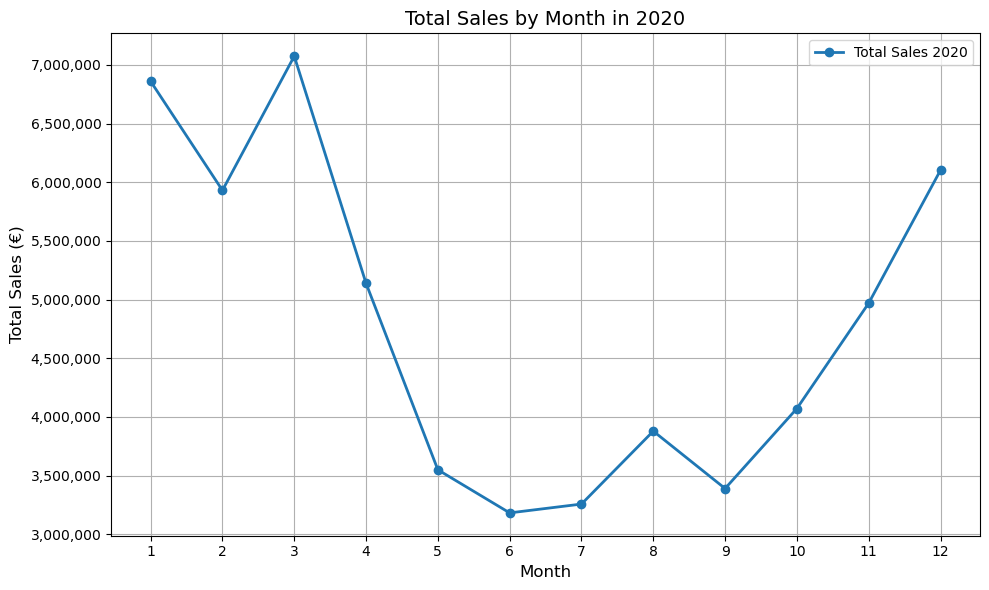

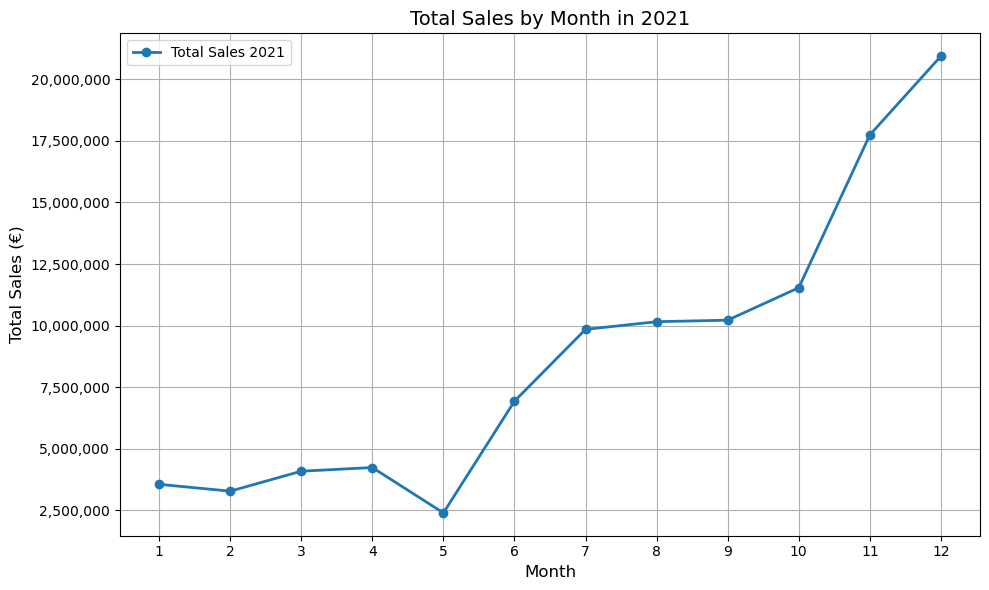

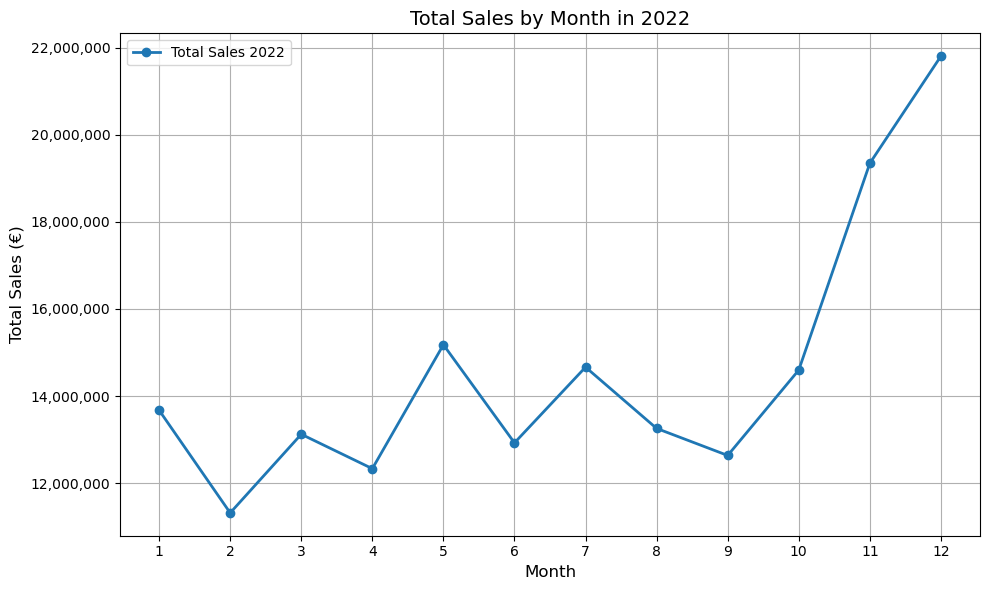

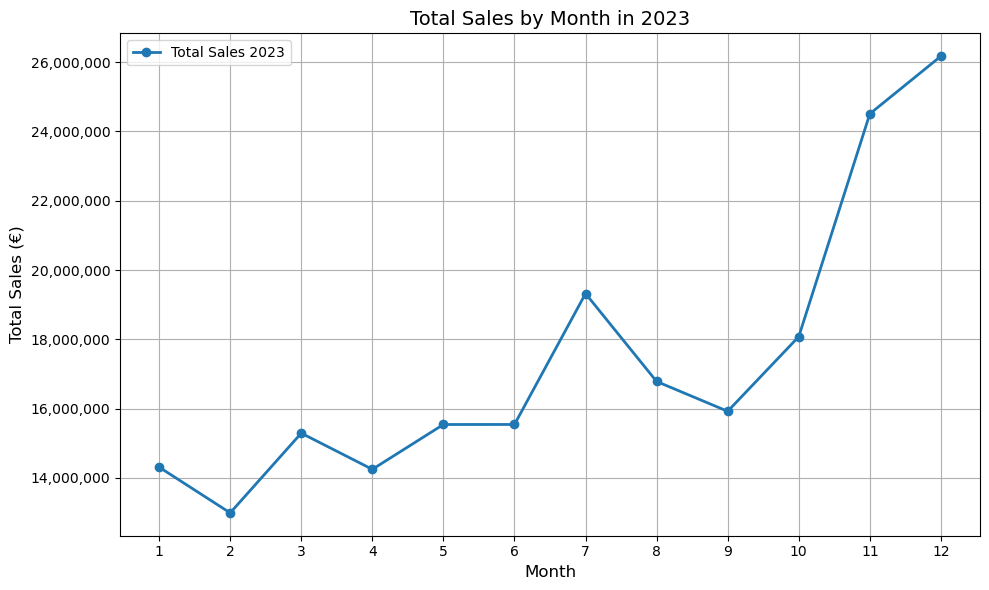

In [14]:
for year in range(2020, 2024):  # Correction : range(2020, 2024) couvre 2020, 2021, 2022, 2023
    # Filtrer les données pour l'année en cours
    df_year = df[df['year'] == year]
    
    # Regrouper par mois et calculer la somme des ventes totales
    monthly_sales = df_year.groupby('month')['order_total_paid_per_day'].sum()
    
    # Tracer les ventes totales pour chaque mois de l'année en cours
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', linewidth=2, label=f'Total Sales {year}')
    
    # Ajouter les étiquettes, le titre et la légende
    plt.title(f'Total Sales by Month in {year}', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Total Sales (€)', fontsize=12)
    
    # Formater l'axe des y pour afficher des nombres entiers avec des virgules
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
    
    # Ajouter les ticks pour les mois
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    # Afficher le graphique
    plt.show()

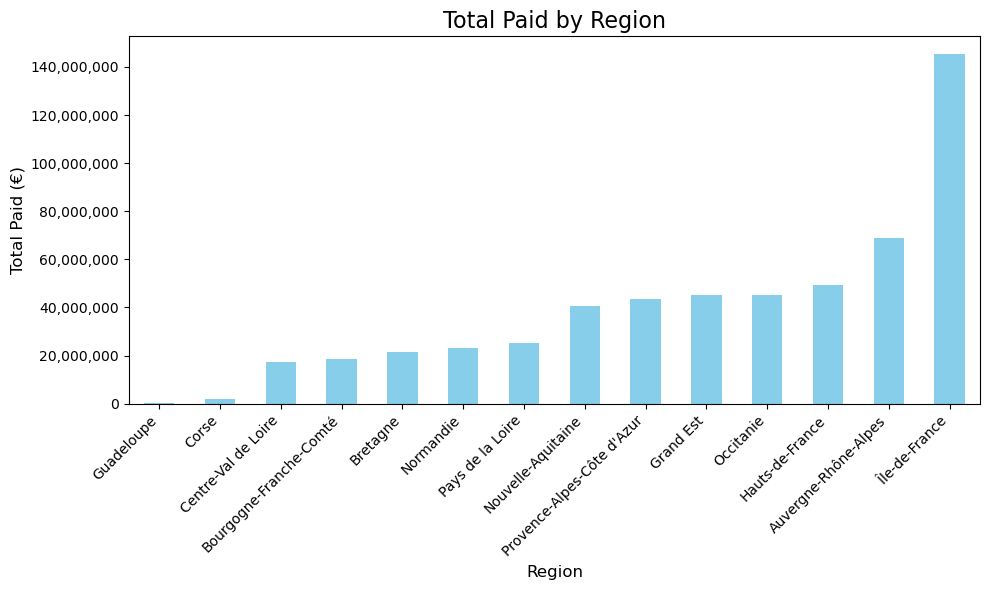

In [15]:
region_totals = df.groupby("order_item_delivery_address_region")["order_total_paid_per_day"].sum()

# Create the plot
plt.figure(figsize=(10, 6))
region_totals.sort_values().plot(kind="bar", color="skyblue")
plt.title("Total Paid by Region", fontsize=16)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Total Paid (€)", fontsize=12)

# Change the y-axis scale to show integers
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

/var/folders/j9/8ym4b6n54plc1gt5xcwrqj_r0000gn/T/ipykernel_58937/1964230203.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_totals = df.groupby(df["order_date"].dt.to_period("M"))["order_total_paid_per_day"].sum()


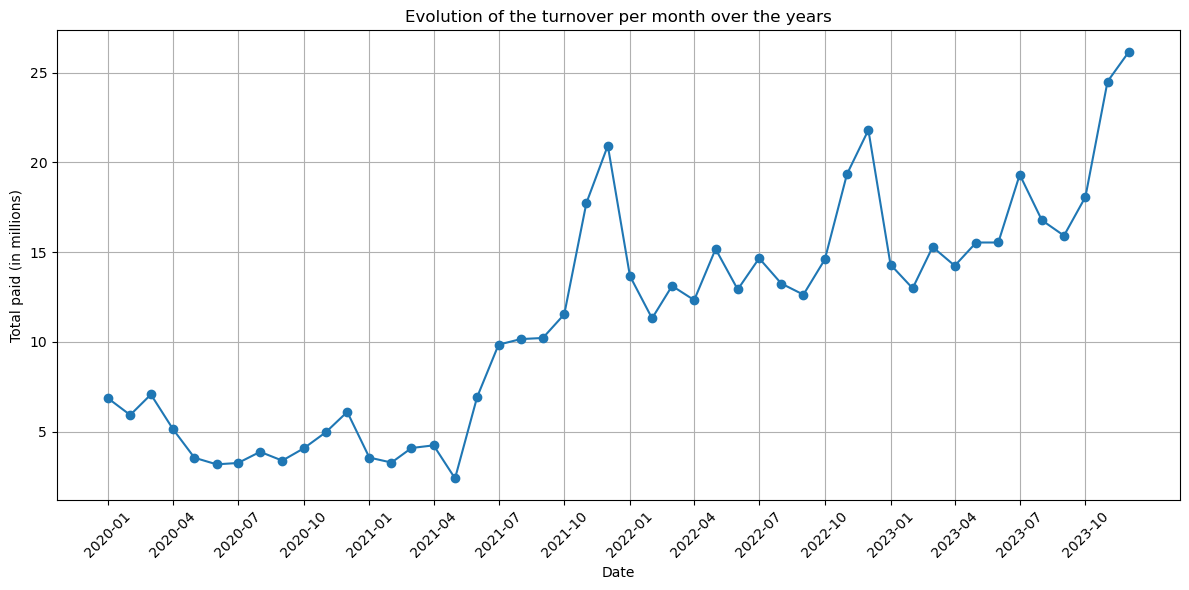

In [16]:
monthly_totals = df.groupby(df["order_date"].dt.to_period("M"))["order_total_paid_per_day"].sum()

# Convertir l'index pour afficher des dates
monthly_totals.index = monthly_totals.index.to_timestamp()
labels = [f"{date.strftime('%Y-%m')}" for date in monthly_totals.index]

# Tracer la courbe
plt.figure(figsize=(12, 6))
plt.plot(monthly_totals.index, monthly_totals.values / 1e6, marker="o", linestyle="-")  # Diviser par 1e6 pour afficher en millions
plt.title("Evolution of the turnover per month over the years")
plt.xlabel("Date")
plt.ylabel("Total paid (in millions)")
plt.grid(True)
plt.xticks(monthly_totals.index[::3], labels[::3], rotation=45)  # Affiche un mois sur trois
plt.tight_layout()
plt.show()

## **Feature Engineering**

In [17]:
# my target being order_total_paid_per_day

df_ = df.copy()

In [18]:

df_["order_date"] = pd.to_datetime(df_["order_date"], errors="coerce")

# Extract features from the date
df_["year"] = df_["order_date"].dt.year
df_["month"] = df_["order_date"].dt.month
df_["day"] = df_["order_date"].dt.day
df_["week_day"] = df_["order_date"].dt.weekday  # Monday=0, Sunday=6

# Drop the "order_date" column as it's no longer needed
df_ = df_.drop(columns=["order_date"])

# Display the first rows of the DataFrame
df_.head()

,week_day,order_item_delivery_address_region,order_total_paid_per_day,year,month,day
0,2,Corse,420.05,2020,1,1
1,2,Occitanie,9791.06,2020,1,1
2,2,Bretagne,3140.09,2020,1,1
3,2,Grand Est,6760.79,2020,1,1
4,2,Nouvelle-Aquitaine,3907.70,2020,1,1


In [19]:
df_ = pd.get_dummies(df_)
df_ = df_.astype(int)
df_

,week_day,order_total_paid_per_day,year,month,day,order_item_delivery_address_region_Auvergne-Rhône-Alpes,order_item_delivery_address_region_Bourgogne-Franche-Comté,order_item_delivery_address_region_Bretagne,order_item_delivery_address_region_Centre-Val de Loire,order_item_delivery_address_region_Corse,order_item_delivery_address_region_Grand Est,order_item_delivery_address_region_Guadeloupe,order_item_delivery_address_region_Hauts-de-France,order_item_delivery_address_region_Normandie,order_item_delivery_address_region_Nouvelle-Aquitaine,order_item_delivery_address_region_Occitanie,order_item_delivery_address_region_Pays de la Loire,order_item_delivery_address_region_Provence-Alpes-Côte d'Azur,order_item_delivery_address_region_Île-de-France
0,2,420,2020,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,2,9791,2020,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2,3140,2020,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2,6760,2020,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2,3907,2020,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24185,6,6964,2023,12,31,0,1,0,0,0,0,0,0,0,0,0,0,0,0
24186,6,26620,2023,12,31,0,0,0,0,0,1,0,0,0,0,0,0,0,0
24187,6,59739,2023,12,31,1,0,0,0,0,0,0,0,0,0,0,0,0,0
24188,6,40683,2023,12,31,0,0,0,0,0,0,0,0,0,0,0,0,1,0


## Trying out different models and look at the best one

In [20]:
# splitting our data

# X-y split
X = df_.drop('order_total_paid_per_day', axis=1)
y = df_['order_total_paid_per_day']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Linear regression

In [21]:
# start the model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# get predictions
predictions = model.predict(X_test)

In [23]:
# The score is pretty low

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.6484599885824431, 10945.300997430348, 18601.140552480294)

In [24]:
import math

res = pd.DataFrame()
res['true'] = y_test
res['pred'] = predictions
res['resid'] = res.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
res

,true,pred,resid
3297,19975,87659.944312,67684.944312
13769,14386,15293.257490,907.257490
12904,16499,17191.710080,692.710080
2321,2467,-6075.544987,8542.544987
24153,20121,29965.902510,9844.902510
...,...,...,...
22905,160137,122926.766971,37210.233029
20622,38101,26751.256598,11349.743402
16454,682,-1052.518092,1734.518092
21341,20772,34421.803096,13649.803096


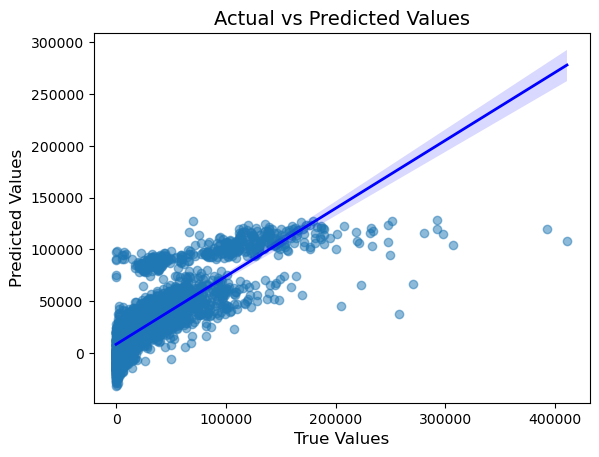

In [25]:
sns.regplot(x=res['true'], y=res['pred'], scatter_kws={"alpha": 0.5}, line_kws={"color": "blue", "linewidth": 2})

# Add labels and a title
plt.title("Actual vs Predicted Values", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)

# Display the plot
plt.show()

#### KNN - K Nearest Neighbors

In [26]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [27]:
knn.score(X_test, y_test)

0.26353441434244873

In [28]:
predictions = knn.predict(X_test)

In [29]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.26353441434244873, 15387.95350877193, 26923.308144300237)

### RandomForest Regressor

In [30]:
forest = RandomForestRegressor()

In [31]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [32]:
forest.score(X_test, y_test)

0.8699914067249495

In [33]:
predictions = forest.predict(X_test)

In [34]:
# The results are really good here

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.8699914067249495, 5379.30630380407, 11311.96942678671)

### **Results**

In [35]:
# Again Random Forest Classifier appears to be the best.

results = pd.DataFrame({
    'Model': ['Linear Regression','KNN', 'Random Forest Regressor'],
    'Score': [round(model.score(X_test, y_test),3),round(knn.score(X_test, y_test),3),round(forest.score(X_test, y_test),3)]})

results_models = results.sort_values(by='Score', ascending=False)
results_models = results_models.set_index('Score')
results_models

,Model
Score,
0.870,Random Forest Regressor
0.648,Linear Regression
0.264,KNN


### **Conclusion**

By getting a score of 87%, we can conclude that without the meteorological features, we are 86% sure that our model will predict the result that makes sense

**________________________________________________________________________________________________**

### **Same process but adding meteorological data**

cities associated to its regions

- Nouvelle-Aquitaine : Bordeaux ;)
- Hauts-de-France : Lille ;)
- Centre-Val de Loire : Orléans ;)
- Île-de-France : Paris ;)
- Corse : Ajaccio ;)
- Occitanie : Toulouse 
- Bretagne : Brest ;)
- Grand Est : Strasbourg ;)
- Provence-Alpes-Côte d'Azur : Marseille ;)
- Bourgogne-Franche-Comté : Dijon ;)
- Auvergne-Rhône-Alpes : Lyon ;)
- Pays de la Loire : Nantes ;)
- Normandie : Rouen ;)
- Guadeloupe : Basse-Terre ;)

In [36]:
df_m = pd.read_excel("meteo_data.xlsx")
df_m

,utc,year,month,day,temperature,wind_speed,precipitations,humidity,city,region
0,2020-01-01 00:00:00+00:00,2020,1,1,2.83,2.83,1.20,98.62,paris,Île-de-France
1,2020-01-02 00:00:00+00:00,2020,1,2,5.26,3.95,1.04,98.19,paris,Île-de-France
2,2020-01-03 00:00:00+00:00,2020,1,3,7.33,6.37,0.81,93.62,paris,Île-de-France
3,2020-01-04 00:00:00+00:00,2020,1,4,4.04,3.16,0.17,93.06,paris,Île-de-France
4,2020-01-05 00:00:00+00:00,2020,1,5,3.70,1.66,0.10,91.25,paris,Île-de-France
...,...,...,...,...,...,...,...,...,...,...
20449,2023-12-27 00:00:00+00:00,2023,12,27,27.22,2.53,0.85,70.44,basse-terre,Guadeloupe
20450,2023-12-28 00:00:00+00:00,2023,12,28,27.11,3.52,0.11,68.00,basse-terre,Guadeloupe
20451,2023-12-29 00:00:00+00:00,2023,12,29,26.99,4.30,0.02,69.88,basse-terre,Guadeloupe
20452,2023-12-30 00:00:00+00:00,2023,12,30,26.76,4.55,0.69,73.25,basse-terre,Guadeloupe


In [37]:
df_m['utc'] = pd.to_datetime(df_m['utc'], utc=True)
df_m['utc'].dtypes

datetime64[ns, UTC]

In [38]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20454 entries, 0 to 20453
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   utc             20454 non-null  datetime64[ns, UTC]
 1   year            20454 non-null  int64              
 2   month           20454 non-null  int64              
 3   day             20454 non-null  int64              
 4   temperature     20454 non-null  float64            
 5   wind_speed      20454 non-null  float64            
 6   precipitations  20454 non-null  float64            
 7   humidity        20454 non-null  float64            
 8   city            20454 non-null  object             
 9   region          20454 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(4), int64(3), object(2)
memory usage: 1.6+ MB


In [39]:
df_m.rename(columns={'utc': 'order_date', 'region': 'order_item_delivery_address_region'}, inplace=True)

# Fusion des DataFrames avec un left join
merged_df = pd.merge(
    df, df_m, 
    on=['order_date', 'order_item_delivery_address_region'], 
    how='left'
)

merged_df

,order_date,week_day,order_item_delivery_address_region,order_total_paid_per_day,year_x,month_x,day_x,year_y,month_y,day_y,temperature,wind_speed,precipitations,humidity,city
0,2020-01-01 00:00:00+00:00,Wednesday,Corse,420.05,2020,1,1,2020.0,1.0,1.0,9.30,1.81,0.00,81.12,ajaccio
1,2020-01-01 00:00:00+00:00,Wednesday,Occitanie,9791.06,2020,1,1,2020.0,1.0,1.0,6.19,1.60,0.01,91.88,toulouse
2,2020-01-01 00:00:00+00:00,Wednesday,Bretagne,3140.09,2020,1,1,2020.0,1.0,1.0,9.36,2.97,0.99,96.12,brest
3,2020-01-01 00:00:00+00:00,Wednesday,Grand Est,6760.79,2020,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01 00:00:00+00:00,Wednesday,Nouvelle-Aquitaine,3907.70,2020,1,1,2020.0,1.0,1.0,8.80,2.45,0.35,95.12,bordeaux
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22795,2023-12-31 00:00:00+00:00,Sunday,Bourgogne-Franche-Comté,6964.15,2023,12,12,2023.0,12.0,31.0,5.86,7.88,4.13,94.94,dijon
22796,2023-12-31 00:00:00+00:00,Sunday,Grand Est,26620.30,2023,12,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22797,2023-12-31 00:00:00+00:00,Sunday,Auvergne-Rhône-Alpes,59739.43,2023,12,12,2023.0,12.0,31.0,7.04,6.21,4.54,92.88,lyon
22798,2023-12-31 00:00:00+00:00,Sunday,Provence-Alpes-Côte d'Azur,40683.11,2023,12,12,2023.0,12.0,31.0,9.48,5.14,0.72,94.69,marseille


In [40]:
# useless columns

col_to_drop = ['city', 'year_y', 'month_y', 'day_y']

merged_df = merged_df.drop(columns=col_to_drop)
merged_df

,order_date,week_day,order_item_delivery_address_region,order_total_paid_per_day,year_x,month_x,day_x,temperature,wind_speed,precipitations,humidity
0,2020-01-01 00:00:00+00:00,Wednesday,Corse,420.05,2020,1,1,9.30,1.81,0.00,81.12
1,2020-01-01 00:00:00+00:00,Wednesday,Occitanie,9791.06,2020,1,1,6.19,1.60,0.01,91.88
2,2020-01-01 00:00:00+00:00,Wednesday,Bretagne,3140.09,2020,1,1,9.36,2.97,0.99,96.12
3,2020-01-01 00:00:00+00:00,Wednesday,Grand Est,6760.79,2020,1,1,NaN,NaN,NaN,NaN
4,2020-01-01 00:00:00+00:00,Wednesday,Nouvelle-Aquitaine,3907.70,2020,1,1,8.80,2.45,0.35,95.12
...,...,...,...,...,...,...,...,...,...,...,...
22795,2023-12-31 00:00:00+00:00,Sunday,Bourgogne-Franche-Comté,6964.15,2023,12,12,5.86,7.88,4.13,94.94
22796,2023-12-31 00:00:00+00:00,Sunday,Grand Est,26620.30,2023,12,12,NaN,NaN,NaN,NaN
22797,2023-12-31 00:00:00+00:00,Sunday,Auvergne-Rhône-Alpes,59739.43,2023,12,12,7.04,6.21,4.54,92.88
22798,2023-12-31 00:00:00+00:00,Sunday,Provence-Alpes-Côte d'Azur,40683.11,2023,12,12,9.48,5.14,0.72,94.69


In [41]:
# adjusting details

# rename
merged_df.rename(columns={'year_x': 'year', 'month_x': 'month','day_x': 'day'}, inplace=True)

# drop nulls (since left join hasn't worked like i would
merged_df = merged_df.dropna().reset_index(drop=True)


# put the target column at the end for a better visualisation
merged_df = merged_df.reindex(
    columns=[col for col in merged_df.columns if col != 'order_total_paid_per_day'] + ['order_total_paid_per_day']
)

merged_df

,order_date,week_day,order_item_delivery_address_region,year,month,day,temperature,wind_speed,precipitations,humidity,order_total_paid_per_day
0,2020-01-01 00:00:00+00:00,Wednesday,Corse,2020,1,1,9.30,1.81,0.00,81.12,420.05
1,2020-01-01 00:00:00+00:00,Wednesday,Occitanie,2020,1,1,6.19,1.60,0.01,91.88,9791.06
2,2020-01-01 00:00:00+00:00,Wednesday,Bretagne,2020,1,1,9.36,2.97,0.99,96.12,3140.09
3,2020-01-01 00:00:00+00:00,Wednesday,Nouvelle-Aquitaine,2020,1,1,8.80,2.45,0.35,95.12,3907.70
4,2020-01-01 00:00:00+00:00,Wednesday,Provence-Alpes-Côte d'Azur,2020,1,1,5.62,1.04,0.01,89.88,6910.38
...,...,...,...,...,...,...,...,...,...,...,...
21334,2023-12-31 00:00:00+00:00,Sunday,Hauts-de-France,2023,12,12,8.55,11.48,3.81,84.94,20563.71
21335,2023-12-31 00:00:00+00:00,Sunday,Bourgogne-Franche-Comté,2023,12,12,5.86,7.88,4.13,94.94,6964.15
21336,2023-12-31 00:00:00+00:00,Sunday,Auvergne-Rhône-Alpes,2023,12,12,7.04,6.21,4.54,92.88,59739.43
21337,2023-12-31 00:00:00+00:00,Sunday,Provence-Alpes-Côte d'Azur,2023,12,12,9.48,5.14,0.72,94.69,40683.11


#### The cleaning has been done before in the first part so we can skip this part

## **EDA**

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


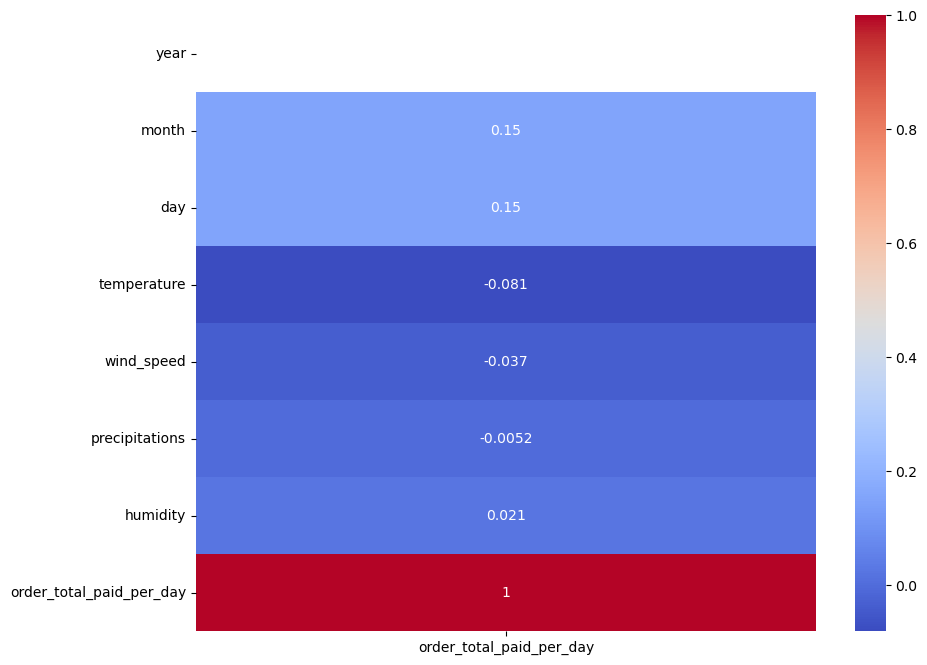

In [42]:
heatmap_df = merged_df.copy().select_dtypes(np.number)


correlations = heatmap_df.corr()[['order_total_paid_per_day']]


mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask)] = True


fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlations, mask=mask, annot=True, cmap="coolwarm", cbar=True, ax=ax)
plt.show()


# Relation isn't strong

In [43]:
merged_df

,order_date,week_day,order_item_delivery_address_region,year,month,day,temperature,wind_speed,precipitations,humidity,order_total_paid_per_day
0,2020-01-01 00:00:00+00:00,Wednesday,Corse,2020,1,1,9.30,1.81,0.00,81.12,420.05
1,2020-01-01 00:00:00+00:00,Wednesday,Occitanie,2020,1,1,6.19,1.60,0.01,91.88,9791.06
2,2020-01-01 00:00:00+00:00,Wednesday,Bretagne,2020,1,1,9.36,2.97,0.99,96.12,3140.09
3,2020-01-01 00:00:00+00:00,Wednesday,Nouvelle-Aquitaine,2020,1,1,8.80,2.45,0.35,95.12,3907.70
4,2020-01-01 00:00:00+00:00,Wednesday,Provence-Alpes-Côte d'Azur,2020,1,1,5.62,1.04,0.01,89.88,6910.38
...,...,...,...,...,...,...,...,...,...,...,...
21334,2023-12-31 00:00:00+00:00,Sunday,Hauts-de-France,2023,12,12,8.55,11.48,3.81,84.94,20563.71
21335,2023-12-31 00:00:00+00:00,Sunday,Bourgogne-Franche-Comté,2023,12,12,5.86,7.88,4.13,94.94,6964.15
21336,2023-12-31 00:00:00+00:00,Sunday,Auvergne-Rhône-Alpes,2023,12,12,7.04,6.21,4.54,92.88,59739.43
21337,2023-12-31 00:00:00+00:00,Sunday,Provence-Alpes-Côte d'Azur,2023,12,12,9.48,5.14,0.72,94.69,40683.11


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

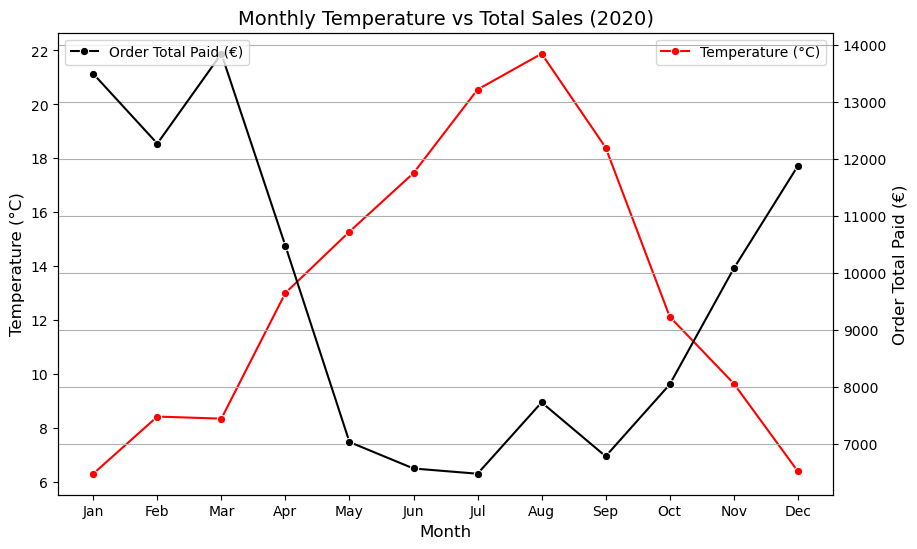

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

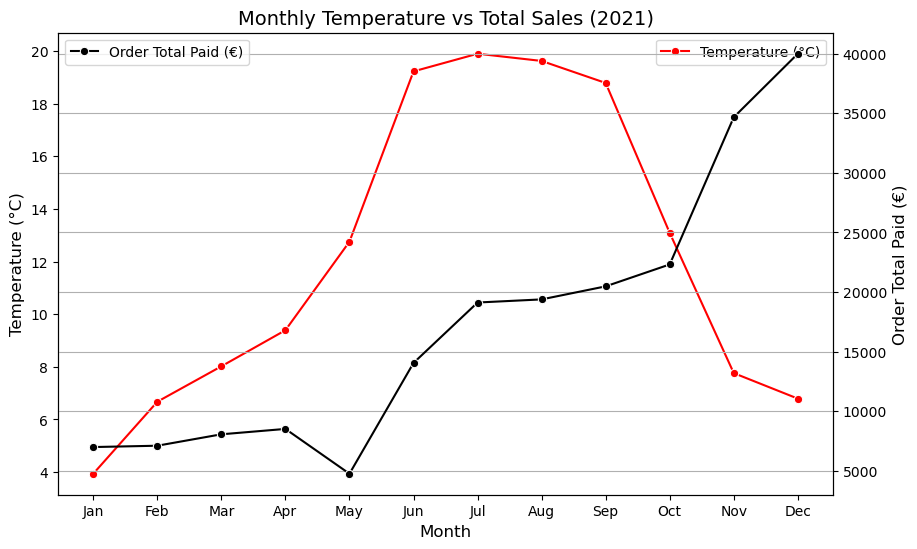

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

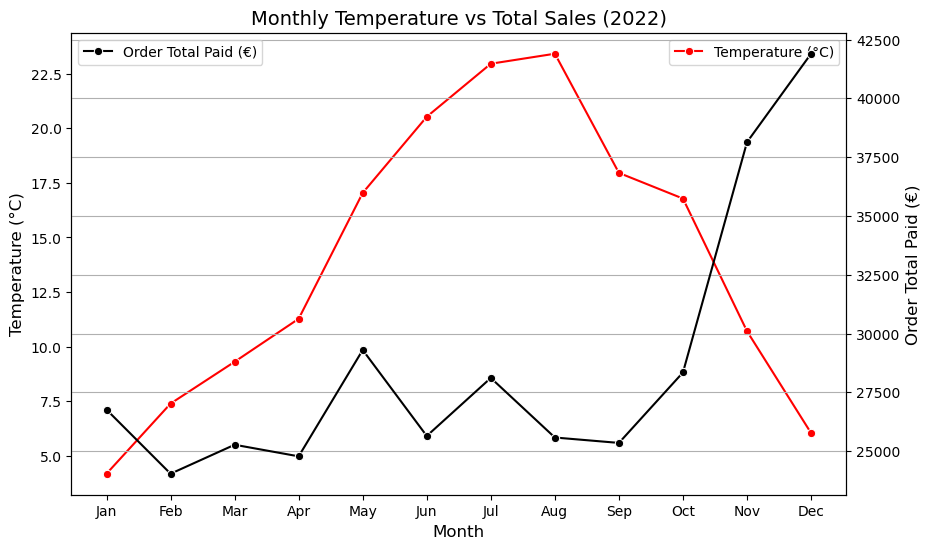

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

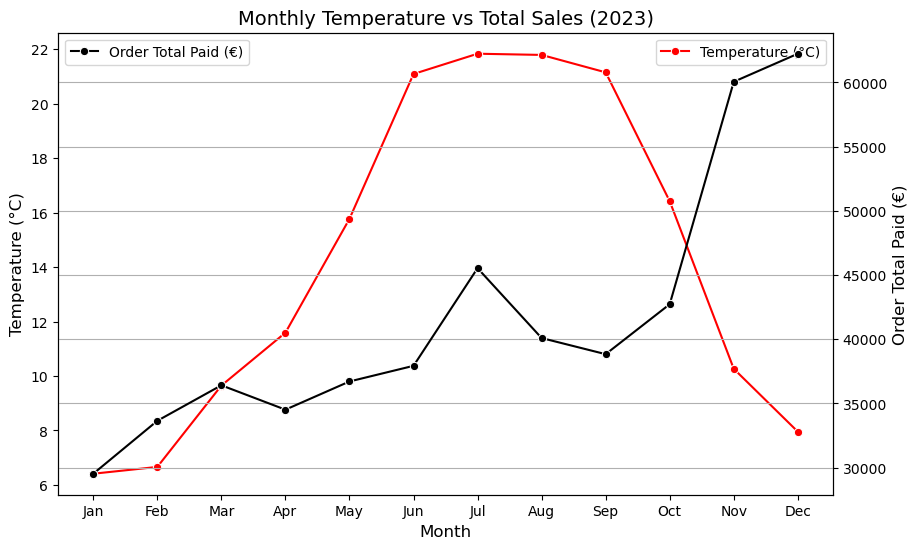

In [44]:
for i in range(2020, 2024):

    df_year = merged_df[merged_df['year'] == i]
    
    # Regrouper par mois pour calculer les moyennes des colonnes 'temperature' et 'order_total_paid_per_day'
    monthly_data = df_year.groupby('month').agg({
        'temperature': 'mean',
        'order_total_paid_per_day': 'mean'
    }).reset_index()
    
    # Tracer les deux séries sur un graphique
    plt.figure(figsize=(10, 6))
    
    # Tracer la température (axe de gauche)
    sns.lineplot(x=monthly_data['month'], y=monthly_data['temperature'], marker='o', label='Temperature (°C)', color='red')
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xlabel('Month', fontsize=12)
    plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    # Ajouter un deuxième axe pour les ventes totales
    ax2 = plt.gca().twinx()  # Crée un second axe Y
    sns.lineplot(x=monthly_data['month'], y=monthly_data['order_total_paid_per_day'], marker='o', label='Order Total Paid (€)', ax=ax2, color='black')
    ax2.set_ylabel('Order Total Paid (€)', fontsize=12)
    ax2.legend(loc='upper right')
    plt.legend(loc='upper left')

    
    # Ajouter une légende et un titre
    plt.title(f"Monthly Temperature vs Total Sales ({i})", fontsize=14)
    plt.grid(True)
    
    plt.show()

# some other relations

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

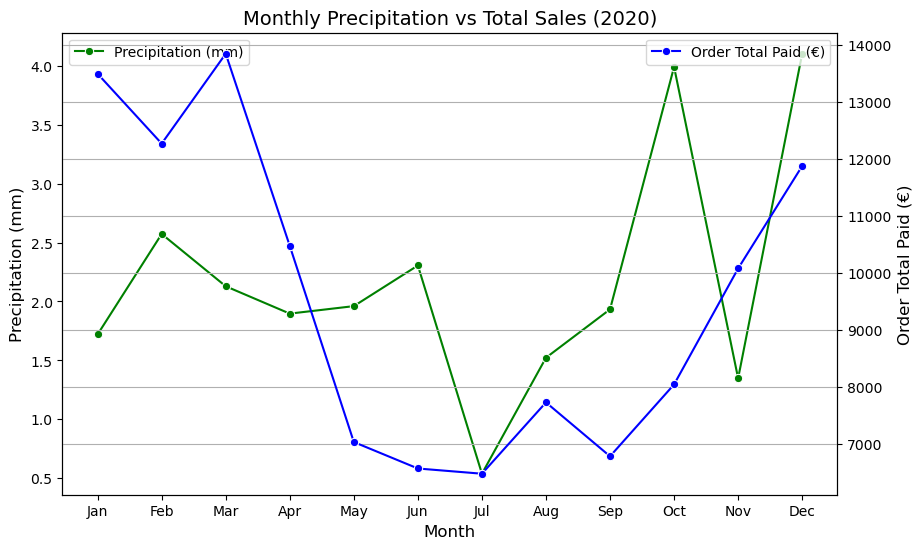

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

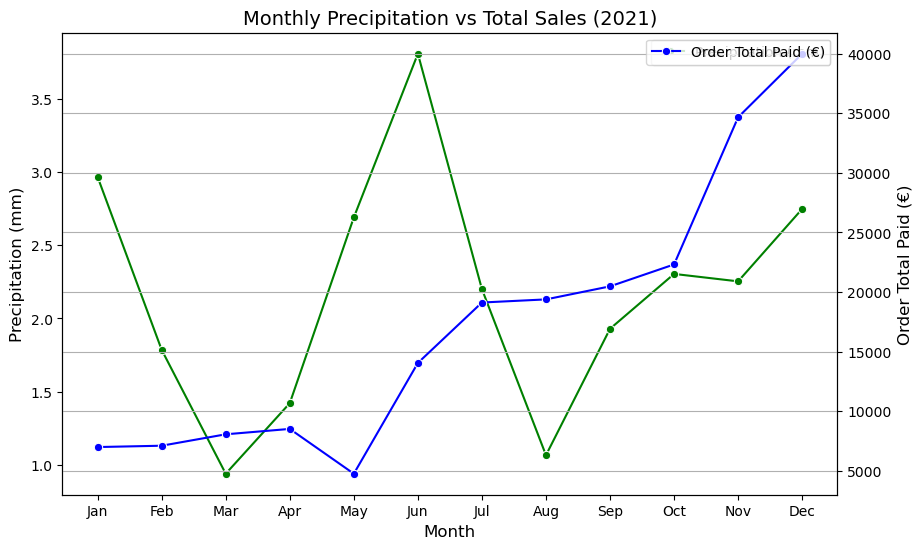

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

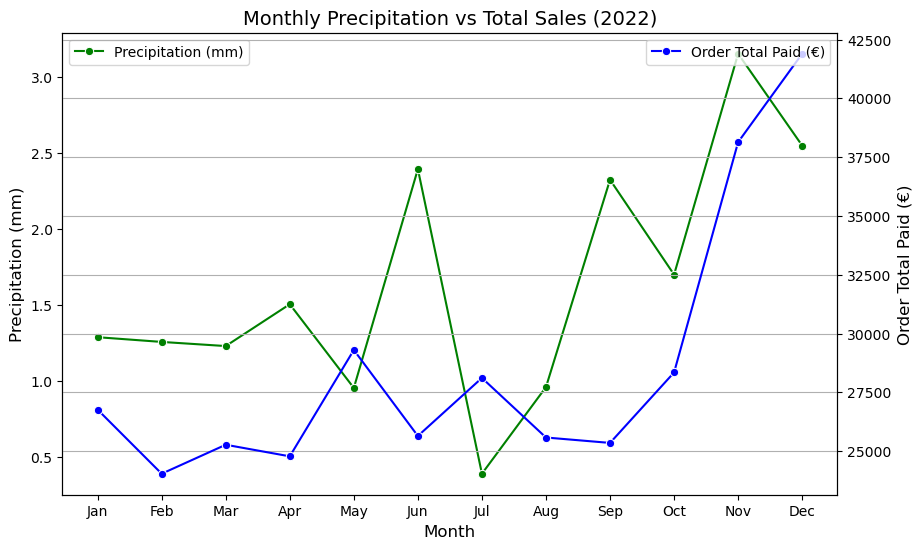

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

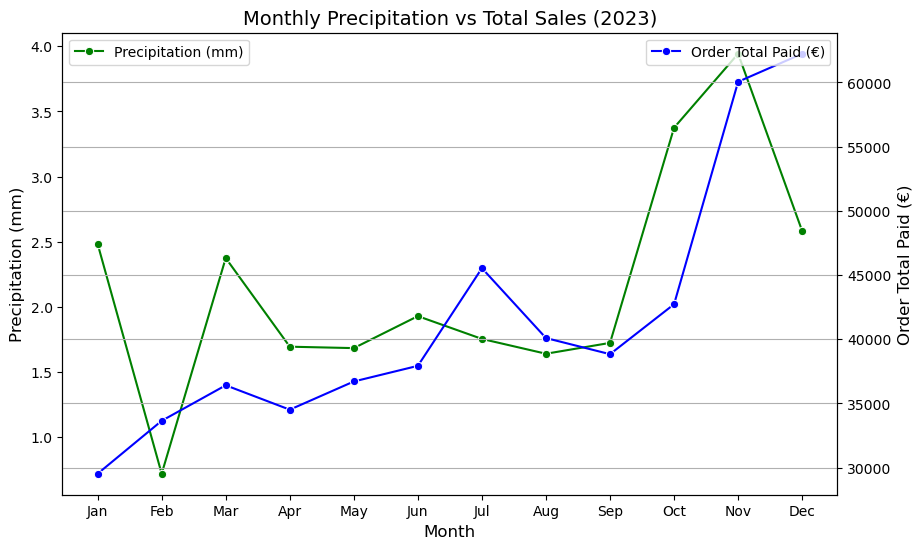

In [45]:
for i in range(2020, 2024):

    df_year = merged_df[merged_df['year'] == i]
    
    # Regrouper par mois pour calculer les moyennes des colonnes 'precipitation' et 'order_total_paid_per_day'
    monthly_data = df_year.groupby('month').agg({
        'precipitations': 'mean',
        'order_total_paid_per_day': 'mean'
    }).reset_index()
    
    # Tracer les deux séries sur un graphique
    plt.figure(figsize=(10, 6))
    
    # Tracer les précipitations (axe de gauche)
    sns.lineplot(x=monthly_data['month'], y=monthly_data['precipitations'], marker='o', label='Precipitation (mm)', color='green')
    plt.ylabel('Precipitation (mm)', fontsize=12)
    plt.xlabel('Month', fontsize=12)
    plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    # Ajouter un deuxième axe pour les ventes totales
    ax2 = plt.gca().twinx()  # Crée un second axe Y
    sns.lineplot(x=monthly_data['month'], y=monthly_data['order_total_paid_per_day'], marker='o', label='Order Total Paid (€)', ax=ax2, color='blue')
    ax2.set_ylabel('Order Total Paid (€)', fontsize=12)
    
    # Ajuster les légendes
    ax2.legend(loc='upper right')

    
    # Ajouter un titre
    plt.title(f'Monthly Precipitation vs Total Sales ({i})', fontsize=14)
    plt.grid(True)
    
    plt.show()
    
    # some other relations

## Feature engineering

In [46]:
df_t = merged_df.copy()

In [47]:
df_t = pd.get_dummies(df_t)
df_t = df_t.astype(int)
df_t = df_t.drop(columns=["order_date"])
df_t

,year,month,day,temperature,wind_speed,precipitations,humidity,order_total_paid_per_day,week_day_Friday,week_day_Monday,...,order_item_delivery_address_region_Centre-Val de Loire,order_item_delivery_address_region_Corse,order_item_delivery_address_region_Guadeloupe,order_item_delivery_address_region_Hauts-de-France,order_item_delivery_address_region_Normandie,order_item_delivery_address_region_Nouvelle-Aquitaine,order_item_delivery_address_region_Occitanie,order_item_delivery_address_region_Pays de la Loire,order_item_delivery_address_region_Provence-Alpes-Côte d'Azur,order_item_delivery_address_region_Île-de-France
0,2020,1,1,9,1,0,81,420,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2020,1,1,6,1,0,91,9791,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2020,1,1,9,2,0,96,3140,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020,1,1,8,2,0,95,3907,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2020,1,1,5,1,0,89,6910,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21334,2023,12,12,8,11,3,84,20563,0,0,...,0,0,0,1,0,0,0,0,0,0
21335,2023,12,12,5,7,4,94,6964,0,0,...,0,0,0,0,0,0,0,0,0,0
21336,2023,12,12,7,6,4,92,59739,0,0,...,0,0,0,0,0,0,0,0,0,0
21337,2023,12,12,9,5,0,94,40683,0,0,...,0,0,0,0,0,0,0,0,1,0


In [48]:
# splitting our data

# X-y split
X = df_t.drop('order_total_paid_per_day', axis=1)
y = df_t['order_total_paid_per_day']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Linear regression

In [49]:
# start the model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

LinearRegression()

In [50]:
# get predictions
predictions = model.predict(X_test)

In [51]:
# slightly better results

r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.6903693821048299, 10787.512630330366, 17896.70769829247)

In [65]:
res = pd.DataFrame()
res['true'] = y_test
res['pred'] = predictions
res['resid'] = res.apply(lambda x: abs(x['true'] - x['pred']), axis=1)
res.head(15)

,true,pred,resid
12528,2941,5769.765667,2828.765667
2687,5740,10347.810000,4607.810000
8191,12710,13292.470000,582.470000
369,2702,1906.884167,795.115833
12222,15174,14848.739000,325.261000
4871,6055,5845.846667,209.153333
13405,15514,7049.513667,8464.486333
12376,11874,7060.397500,4813.602500
10547,41463,24131.735000,17331.265000
1097,8037,4928.903333,3108.096667


In [66]:
res.sort_values('resid', ascending=True).head(15)

,true,pred,resid
11026,138,139.720000,1.720000
12315,91960,91958.183333,1.816667
13260,14384,14381.241667,2.758333
17694,1444,1447.070000,3.070000
7772,1376,1372.887500,3.112500
5849,8608,8604.600000,3.400000
11921,185,188.720000,3.720000
8285,1494,1497.960000,3.960000
10564,122,118.010000,3.990000
18679,111,116.200000,5.200000


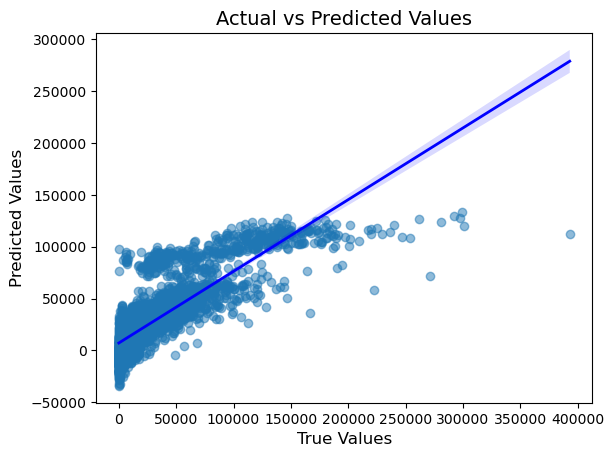

In [53]:
sns.regplot(x=res['true'], y=res['pred'], scatter_kws={"alpha": 0.5}, line_kws={"color": "blue", "linewidth": 2})

# Add labels and a title
plt.title("Actual vs Predicted Values", fontsize=14)
plt.xlabel("True Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)

# Display the plot
plt.show()

#### KNN - K Nearest Neighbors

In [54]:
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

In [55]:
knn.score(X_test, y_test)

0.10055280786220067

### RandomForest Regressor

In [56]:
forest = RandomForestRegressor()

In [57]:
forest.fit(X_train, y_train)

RandomForestRegressor()

In [58]:
forest.score(X_test, y_test)

0.8506815060481295

In [59]:
predictions = forest.predict(X_test)

In [60]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), mean_squared_error(y_test, predictions, squared=False)

(0.8506815060481295, 6270.8036156998305, 12428.193194601261)

## **Results with new features**

In [67]:
# Again Random Forest Classifier appears to be the best.

results = pd.DataFrame({
    'Model (with weather features)': ['Linear Regression','KNN', 'Random Forest Regressor'],
    'Score': [round(model.score(X_test, y_test),3),round(knn.score(X_test, y_test),3),round(forest.score(X_test, y_test),3)]})

results_models = results.sort_values(by='Score', ascending=False)
results_models = results_models.set_index('Score')
results_models

,Model (with weather features)
Score,
0.851,Random Forest Regressor
0.690,Linear Regression
0.101,KNN
